In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data
promoter = pd.read_csv('/kaggle/input/promoter-or-not-bioinformatics-dataset/promoter.csv')
non_promoter = pd.read_csv('/kaggle/input/promoter-or-not-bioinformatics-dataset/non_promoter.csv')

colnames = ['triplet', 'score']
patterns_table = pd.read_csv('/kaggle/input/promoter-or-not-bioinformatics-dataset/bendability.tsv', sep='\t', names=colnames)

# Sliding Window Conversion
* Need to convert sequences to their respective bendability score 

In [2]:
# Create a dictionary of triplet bendability, faster look up than searching patterns_table repeatedly
triplet_score_dict = dict(zip(patterns_table['triplet'], patterns_table['score']))
#print(triplet_score_dict)

def calculate_bendability(sequence):
    '''Calculates the bendability score for the dataset'''
    
    triplet_scores = []
    for i in range(len(sequence) - 2):
        triplet = sequence[i:i+3].lower()
        
        # Use the dictionary for fast lookups
        score = triplet_score_dict.get(triplet)
        if score is not None:
            triplet_scores.append(score)
            
    return np.mean(triplet_scores) if triplet_scores else 0 

# Apply for promoters
promoter_scores = promoter['Promoter sequences'].apply(calculate_bendability)
print(promoter_scores)

# Apply for non promoters
non_promoter_scores = non_promoter['non Promoter sequences'].apply(calculate_bendability)
print(non_promoter_scores)

0       -0.021488
1       -0.011666
2       -0.021946
3       -0.034619
4       -0.024355
           ...   
29995   -0.009094
29996   -0.017395
29997   -0.030421
29998   -0.013629
29999   -0.019990
Name: Promoter sequences, Length: 30000, dtype: float64
0       -0.003024
1       -0.042928
2       -0.011924
3        0.001193
4       -0.023277
           ...   
29995   -0.005112
29996   -0.036032
29997   -0.041349
29998   -0.043088
29999   -0.022912
Name: non Promoter sequences, Length: 30000, dtype: float64


# Train models
* Try Random Forest and KNN for binary classification

In [3]:
# Prepare data for models
data = pd.DataFrame({
    'score': np.concatenate((promoter_scores, non_promoter_scores)),
    'label': ['promoter'] * len(promoter_scores) + ['non-promoter'] * len(non_promoter_scores)
})

# Convert labels to binary
data['label'] = data['label'].map({'promoter': 1, 'non-promoter': 0})

# Split data into train and test sets
X = data[['score']]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# K-Nearest Neighbors Classifier
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

# Evaluate Random Forest
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, rf_predictions))
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

# Evaluate K-Nearest Neighbors
print("K-Nearest Neighbors Confusion Matrix:")
print(confusion_matrix(y_test, knn_predictions))
print("\nK-Nearest Neighbors Classification Report:")
print(classification_report(y_test, knn_predictions))

Random Forest Confusion Matrix:
[[4934 1066]
 [1322 4678]]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      6000
           1       0.81      0.78      0.80      6000

    accuracy                           0.80     12000
   macro avg       0.80      0.80      0.80     12000
weighted avg       0.80      0.80      0.80     12000

K-Nearest Neighbors Confusion Matrix:
[[5028  972]
 [1244 4756]]

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      6000
           1       0.83      0.79      0.81      6000

    accuracy                           0.82     12000
   macro avg       0.82      0.82      0.82     12000
weighted avg       0.82      0.82      0.82     12000



# Optimum neighbour number for KNN

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

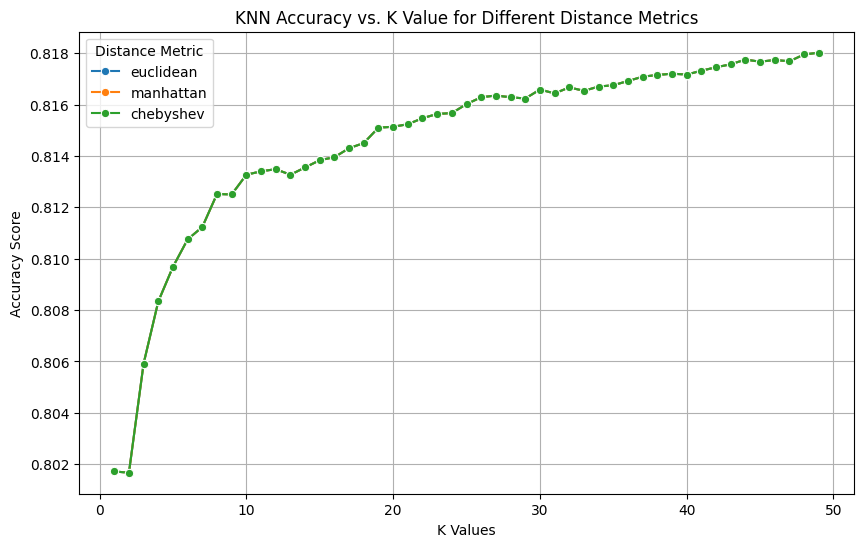

In [4]:
# Standardise features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Initialise k values and score list
k_values = range(1, 50)
scores = []

# Evaluate KNN with different distance metrics and weights
distance_metrics = ['euclidean', 'manhattan', 'chebyshev']
for metric in distance_metrics:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights='distance')
        score = cross_val_score(knn, X, y, cv=5)
        scores.append((k, metric, np.mean(score)))
results = pd.DataFrame(scores, columns=['k', 'metric', 'score'])

#Visualise the results
plt.figure(figsize=(10, 6))
for metric in distance_metrics:
    subset = results[results['metric'] == metric]
    sns.lineplot(x=subset['k'], y=subset['score'], label=metric, marker='o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
plt.title("KNN Accuracy vs. K Value for Different Distance Metrics")
plt.grid()
plt.legend(title='Distance Metric')
plt.show()

# Higher Dimensionality Data
* GC Content: (G count+C count)/total length of the sequence.

In [5]:
def calculate_GC(sequence):
    '''Calculates the GC Content for the dataset'''
    seq_gc = (sequence.count('G') + sequence.count('C')) / len(sequence)
    return seq_gc

# Apply for promoters
promoter_gc_score = promoter['Promoter sequences'].apply(calculate_GC)
print(promoter_gc_score)

# Apply for non promoters
non_promoter_gc_scores = non_promoter['non Promoter sequences'].apply(calculate_GC)
print(non_promoter_gc_scores)

0        0.561462
1        0.531561
2        0.445183
3        0.395349
4        0.561462
           ...   
29995    0.787375
29996    0.651163
29997    0.451827
29998    0.784053
29999    0.691030
Name: Promoter sequences, Length: 30000, dtype: float64
0        0.486056
1        0.378486
2        0.509960
3        0.653386
4        0.505976
           ...   
29995    0.565737
29996    0.314741
29997    0.430279
29998    0.266932
29999    0.593625
Name: non Promoter sequences, Length: 30000, dtype: float64


In [6]:
# Create a combined DataFrame for promoters
promoter_features = pd.DataFrame({
    'bendability': promoter_scores,
    'gc_score': promoter_gc_score
})

# Create a combined DataFrame for non-promoters
non_promoter_features = pd.DataFrame({
    'bendability': non_promoter_scores,
    'gc_score': non_promoter_gc_scores 
})

#print("Promoter Features:\n", promoter_features)
#print("Non-Promoter Features:\n", non_promoter_features)

In [7]:
# Combine promoter and non-promoter features into single df
combined_features = pd.concat([promoter_features, non_promoter_features], axis=0)
combined_features['label'] = ['promoter'] * len(promoter_features) + ['non-promoter'] * len(non_promoter_features)
#print(combined_features.head())

In [8]:
# Separate features and labels
X = combined_features[['bendability', 'gc_score']]
y = combined_features['label']

# Standardise features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Initialise PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.79822603 0.20177397]


In [10]:
# DataFrame for PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['label'] = y.values
# print(pca_df.head())


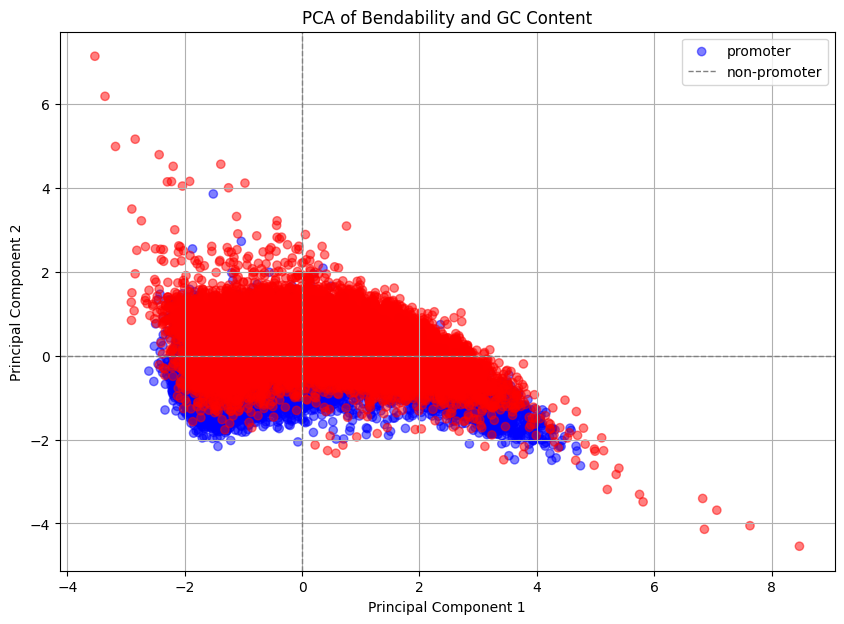

In [11]:
# Plot PCA
plt.figure(figsize=(10, 7))
colors = {'promoter': 'blue', 'non-promoter': 'red'}
plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], 
            c=pca_df['label'].apply(lambda x: colors[x]), alpha=0.5)
plt.title('PCA of Bendability and GC Content')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.axhline(0, color='grey', lw=1, ls='--')
plt.axvline(0, color='grey', lw=1, ls='--')
plt.grid()
plt.legend(colors.keys())
plt.show()